In [3]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
import os
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import sys

# sys.path.append('/nfs/pic.es/user/i/ipinto/Auxiliar files')
print('Auxiliar files')
# import ImageTreatment_and_interfaces as ii
path = Path()
os.path.abspath('')
path

Auxiliar files


Path('.')

# Load data


In [2]:
#Create dataset
file_name = 'nps_data.csv'
if not os.path.exists(file_name):
    folders_files = []
    folders_names = []
    paths = [path/'images_M/background_con_ruido', path/'images_M/imagenes_con_ruido']
    for folder in paths:
        label = folder.name
        files = [file.name for file in folder.iterdir() if file.name[-3:]== 'png']
        folders_files.extend(files)
        folders_names.extend([folder.name]*len(files))
    df = pd.DataFrame(data = {'file name' : folders_files, 'labels' : folders_names})
    print('Creating dataset\n\n',df.head())
    df.to_csv(file_name, index = False)
    
else: 
    df = pd.read_csv(file_name)
    print('Loading dataset \n\n',df.head())

Loading dataset 

   file name labels
0  1088.png   Peak
1  1090.png   Peak
2  1087.png   Peak
3  1089.png   Peak
4  1091.png   Peak


In [3]:
def get_x(r): return path/r['labels']/r['file name']
def get_y(r): return r['labels']

In [4]:
dblock = DataBlock(blocks  = (ImageBlock, CategoryBlock), 
                   get_x = get_x, 
                   get_y = get_y,
                   item_tfms = Resize(16)) 

dsets = dblock.datasets(df)
dls = dblock.dataloaders(df)

['Noise', 'Peak']
(32, 32)


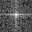

In [5]:
print(dsets.train.vocab)
print(dsets.train[100][0].shape)
dsets.train[100][0]

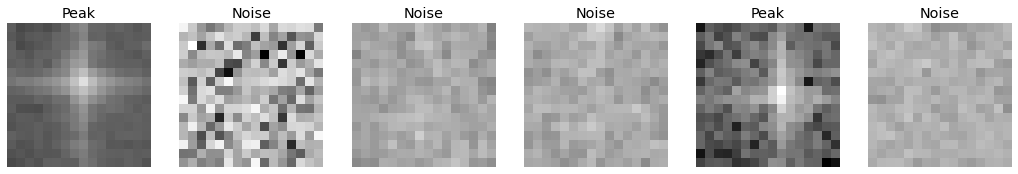

In [6]:
dls.show_batch(nrows = 1, ncols = 6)

# Train and save NN

In [7]:
learn = vision_learner(dls, resnet34, metrics = error_rate)
_ = learn.cuda()

# learn.lr_find()
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.247432,1.227211,0.564103,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.019824,1.110366,0.564103,00:04


In [8]:
i = 0

while(learn.final_record[2]>0.2):
    learn = vision_learner(dls, resnet34, metrics = error_rate)
    _ = learn.cuda()

    #Train
    learn.fine_tune(4, freeze_epochs = 3)
    i += 1

epoch,train_loss,valid_loss,error_rate,time
0,1.148342,0.534527,0.333333,00:04
1,1.094380,0.320092,0.076923,00:04
2,0.889942,0.235125,0.076923,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.510061,0.244361,0.102564,00:04
1,0.387185,0.208982,0.102564,00:04
2,0.342396,0.164622,0.051282,00:04
3,0.305685,0.145167,0.025641,00:04


In [9]:
learn.final_record[2]

0.025641024112701416

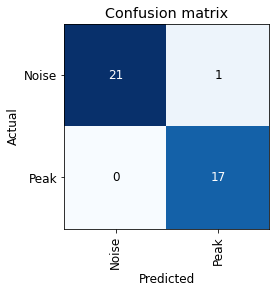

In [10]:
interp1 = ClassificationInterpretation.from_learner(learn)
interp1.plot_confusion_matrix()

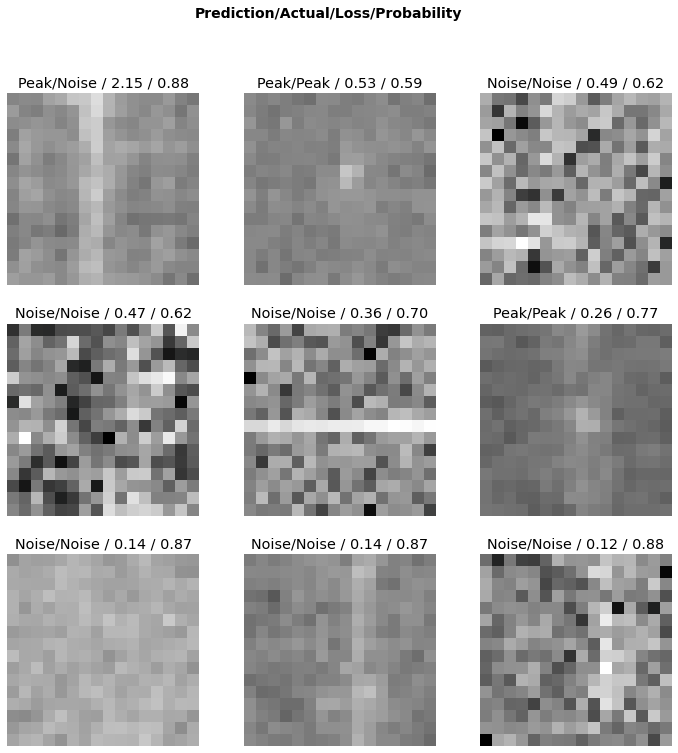

In [11]:
interp1.plot_top_losses(9, nrows=3, figsize=(12,12))

# Save data

In [15]:
filepath = os.path.abspath('')
filename = 'Peaks_detector1.pkl'

# learn.export(filepath + "/" + filename)

# Load and test NN

In [12]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#Charge your model
path = Path()
models = path.ls(file_exts='.pkl')

models

(#3) [Path('Peaks_detector95.pkl'),Path('Peaks_detector97.pkl'),Path('Peaks_detector100.pkl')]

In [13]:
model = models[0]
print(f'Charging model: {model}')

def get_x(r): return path/r['labels']/r['file name']
def get_y(r): return r['labels']

learn_inf = load_learner(path/model)

Charging model: Peaks_detector95.pkl


### Training data

Noise 0.22961056232452393


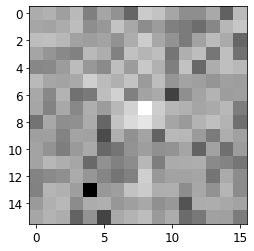

In [14]:
abspath = os.path.abspath("Peak")
test_images = os.listdir(abspath)
n_img = np.random.randint(len(test_images))
img = mpimg.imread(abspath + '/' + test_images[n_img])



img_format = np.uint8(img*255) #We need change the format
pred = learn_inf.predict(img_format)

print(pred[0],float(pred[2][1]))
plt.imshow(img, cmap = 'gray')
plt.show()

### Test data

Peak 0.9978981018066406 1100.png


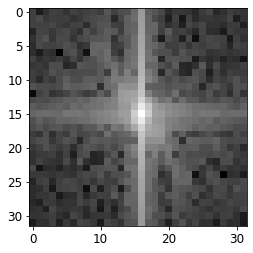

Peak 0.991037130355835 1105.png


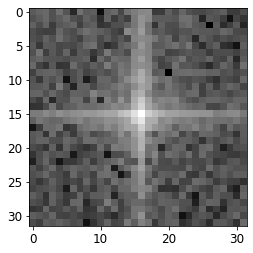

Peak 0.6959320306777954 1103.png


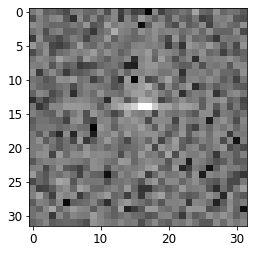

Peak 0.9940574169158936 1102.png


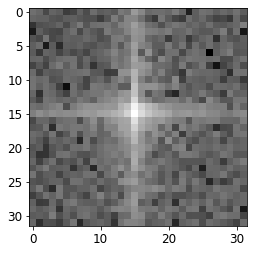

Peak 0.9682037234306335 1104.png


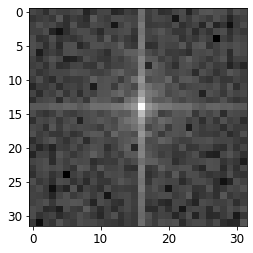

Peak 0.962984025478363 1101.png


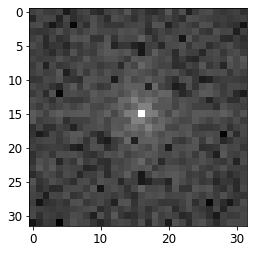

Peak 0.96145099401474 1108.png


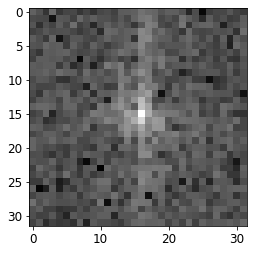

Peak 0.9980600476264954 1107.png


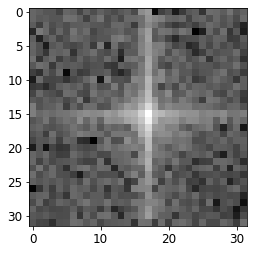

Peak 0.8599827289581299 1109.png


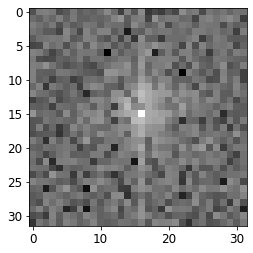

Peak 0.6169890761375427 1106.png


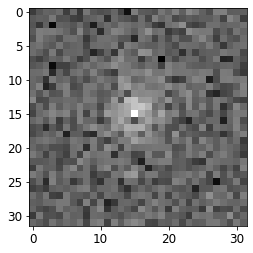

Peak 0.6746920943260193 1202.png


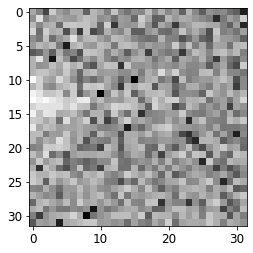

Noise 0.00011297778837615624 1200.png


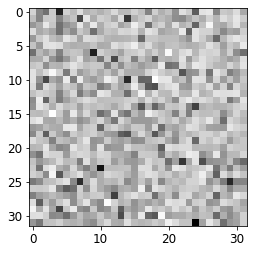

Noise 0.009493174962699413 1201.png


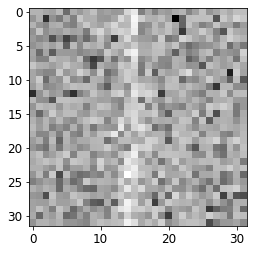

Peak 0.9501047730445862 1204.png


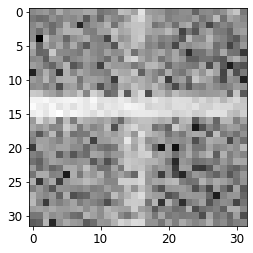

Noise 0.004056920763105154 1205.png


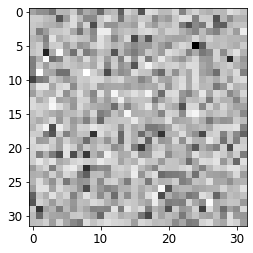

Noise 0.15223471820354462 1203.png


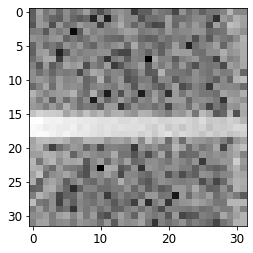

Peak 0.7508490681648254 1207.png


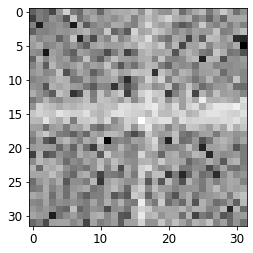

Noise 0.013479969464242458 1208.png


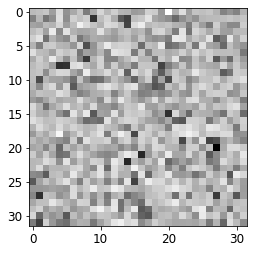

Noise 0.1218043714761734 1206.png


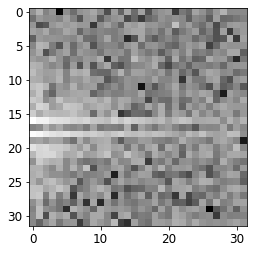

Noise 0.011999230831861496 1209.png


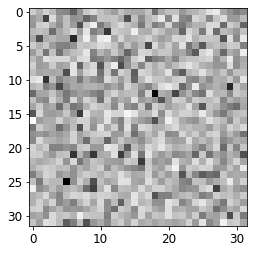

In [15]:
abspath = os.path.abspath("Test")
test_images = os.listdir(abspath)

for image in test_images:
    img = mpimg.imread(abspath + '/' + image)

    img_format = np.uint8(img*255) #We need change the format
    pred = learn_inf.predict(img_format)

    print(pred[0],float(pred[2][1]), image)
    plt.imshow(img, cmap = 'gray')
    plt.show()

### Full FFT spectra

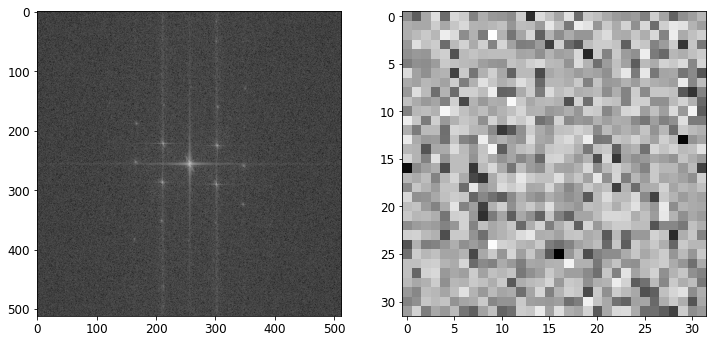

In [16]:
fft = mpimg.imread('fft.png')
fft_format = np.uint8(fft*255)
zoom = fft_format[110:142, 110:142]
ii.multiplot(fft,zoom)

Peak 0.8366324305534363


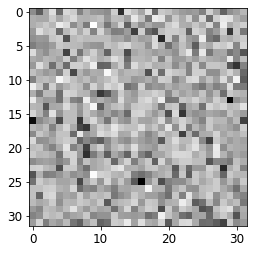

Noise 0.00025694642681628466


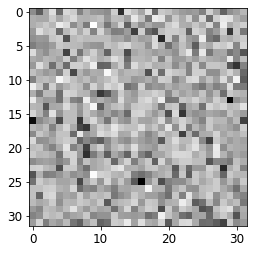

In [17]:
pred = learn_inf.predict(zoom)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom, cmap = 'gray')
plt.show()

#Normalize
zoom_normalize = np.uint8(ii.normalize_image(zoom)*255)
pred = learn_inf.predict(zoom_normalize)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom_normalize, cmap = 'gray')
plt.show()

In [18]:
# def scan(img, size = 32, command = learn_inf.predict, step = 1):
#     n = len(img) - size
#     img_scan = img*0
#     for i in tqdm(range(0,n,step)):
#         for j in range(0,n,step):
#             pred = command(np.uint8(ii.normalize_image(img[i : i + size, j: j + size])*255))
#             img_scan[i + size//2, j + size//2] = float(pred[2][1])*255

#     return img_scan


def scan(img, size = 32, command = learn_inf.predict, step = 1):
    n = len(img) - size
    img_scan = img*0
    for i in tqdm(range(0,n+1,step)):
        for j in range(0,n+1,step):
            pred = command(np.uint8(ii.normalize_image(img[i : i + size, j: j + size])*255))
            img_scan[i : i + size, j: j + size] =  float(pred[2][1])*255
            
            if pred[0] == 'Peak':
                region = img*0 
                region[i : i + size, j: j + size] = 1
                ii.multiplot(img[i : i + size, j: j + size],region, region*img)
            
    return img_scan

  0%|          | 0/16 [00:00<?, ?it/s]

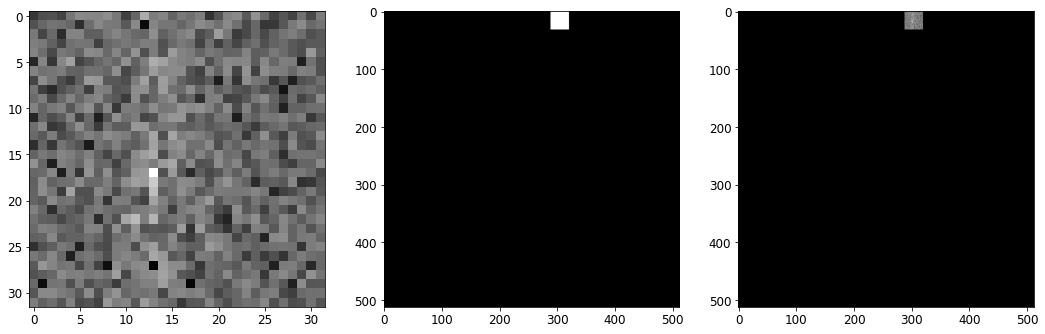

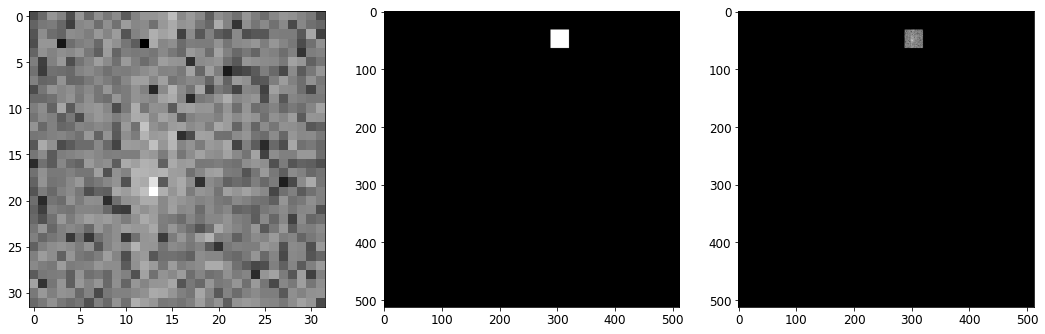

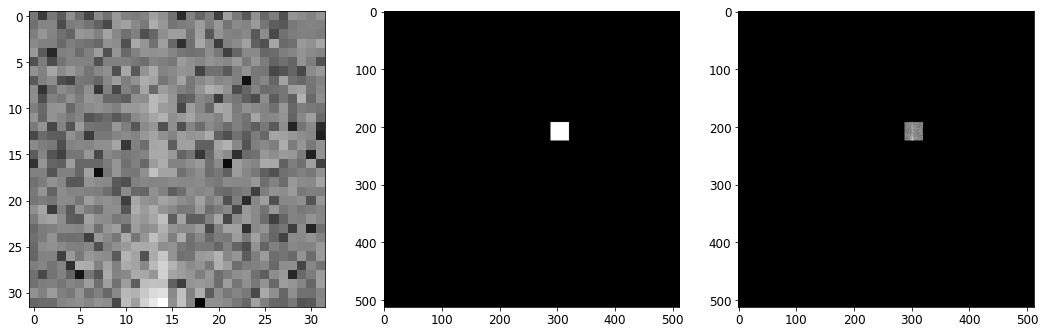

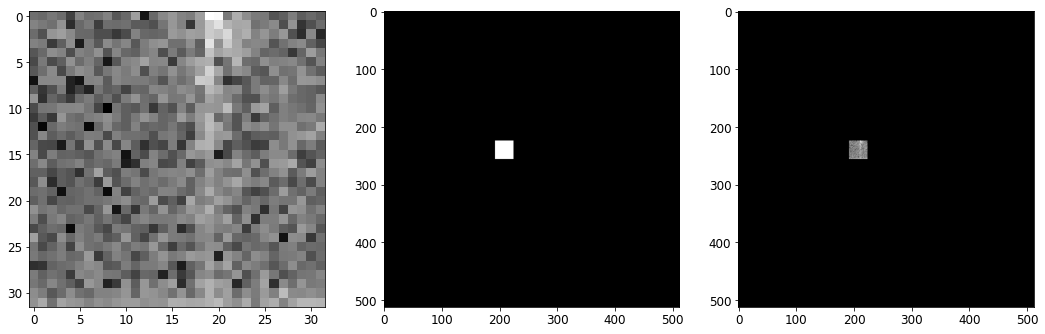

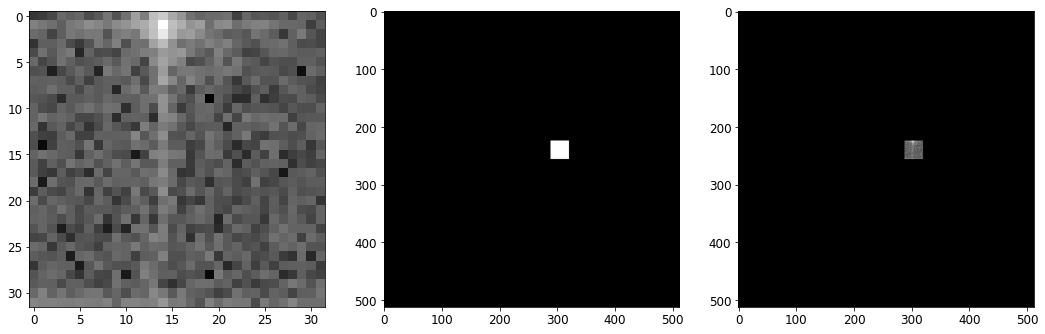

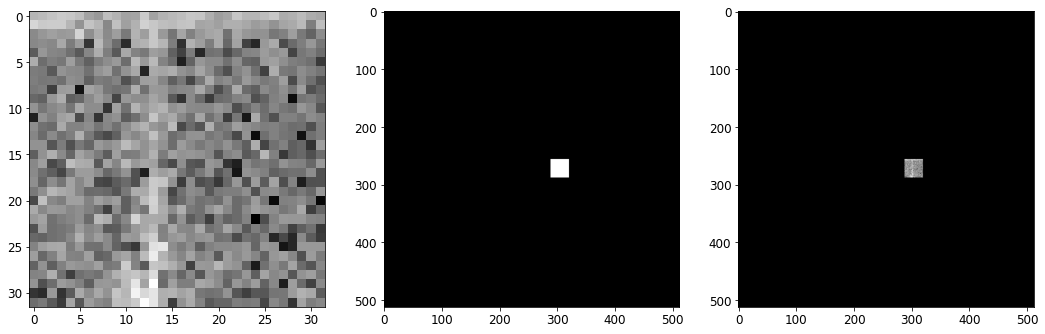

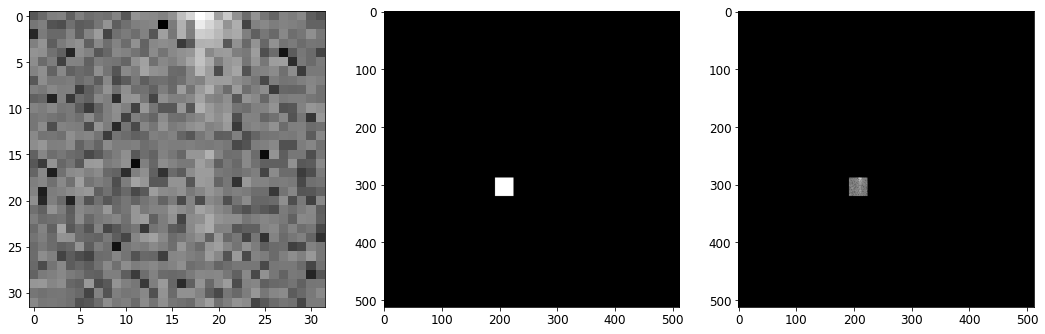

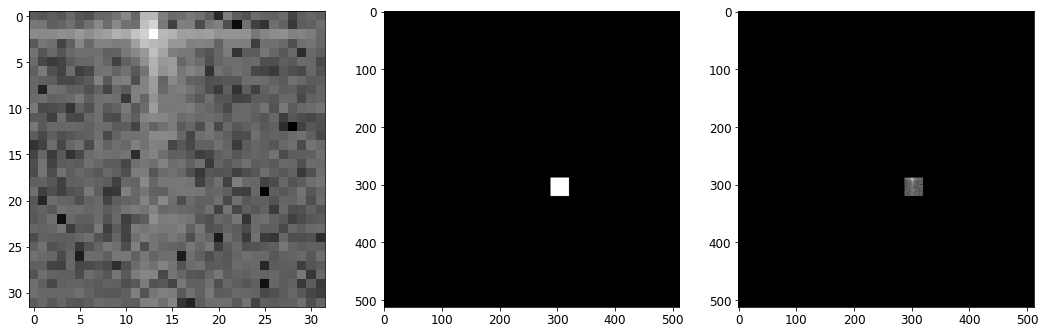

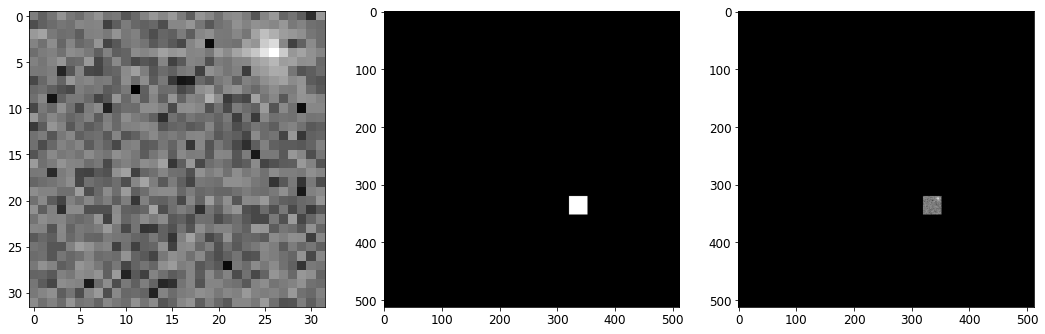

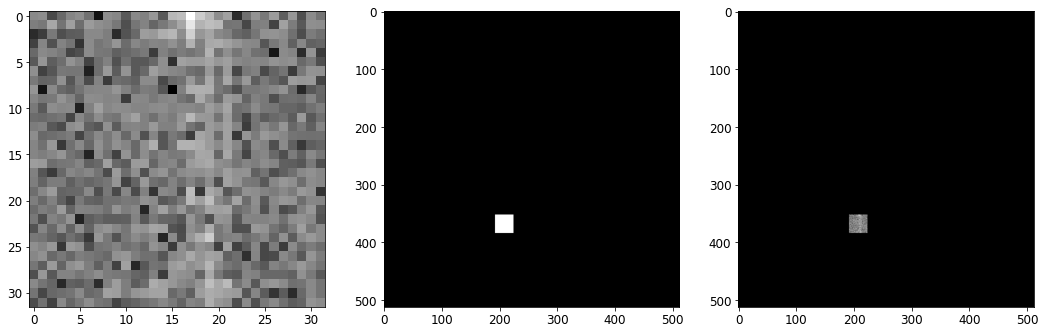

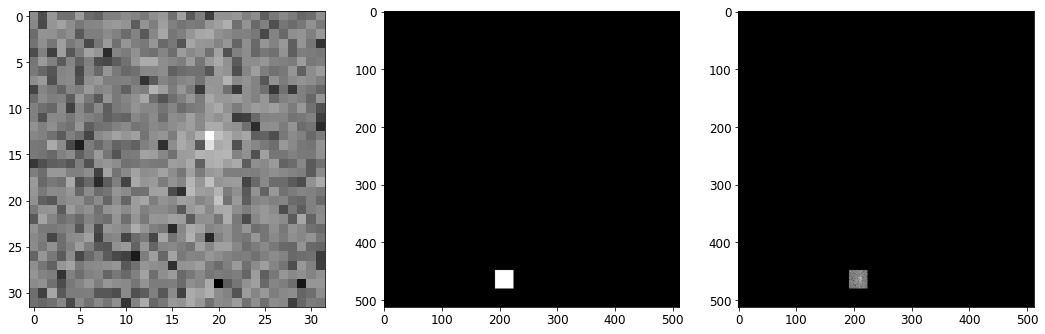

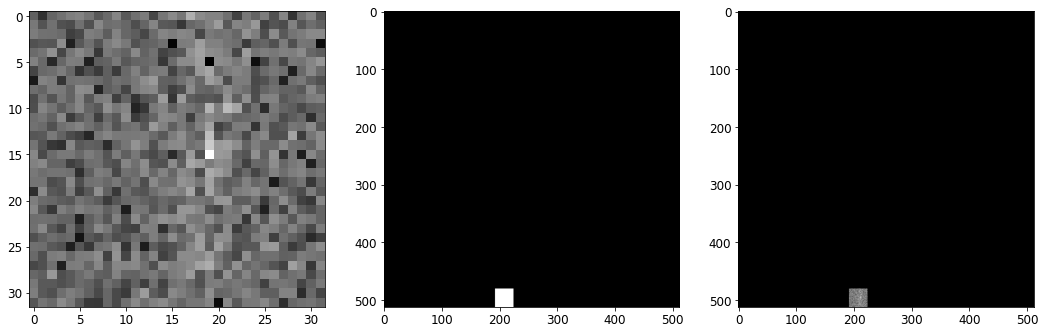

In [19]:
peaks_pred = scan(fft_format, step = 32)

In [20]:
!jupyter labextension list

JupyterLab v3.4.3
/data/jupyter/software/envs/jupyter_edaba7d5d623244d_4a24a2011364cc57/share/jupyter/labextensions
        jupyterlab_pygments v0.2.2 enabled OK (python, jupyterlab_pygments)
        jupyterlab-plotly v5.8.2 enabled OK
        jupyterlab-jupytext v1.3.8 enabled OK (python, jupytext)
        nbdime-jupyterlab v2.2.0 enabled OK
        dask-labextension v6.0.0 enabled OK (python, dask_labextension)
        jupyterlab-nvdashboard v0.7.0 enabled OK (python, jupyterlab_nvdashboard)
        jupyterlab-topbar-extension v0.6.1 enabled OK (python, jupyterlab-topbar)
        jupyterlab-system-monitor v0.8.0 enabled OK (python, jupyterlab-system-monitor)
        jupyter-matplotlib v0.10.5 enabled OK
        @jupyter-widgets/jupyterlab-manager v3.1.0 enabled OK (python, jupyterlab_widgets)
        @jupyter-server/resource-usage v0.6.1 enabled OK (python, jupyter-resource-usage)
        @jupyterlab/server-proxy v3.2.1 enabled OK
        @jupyterlab/git v0.37.1 enabled OK (python, j

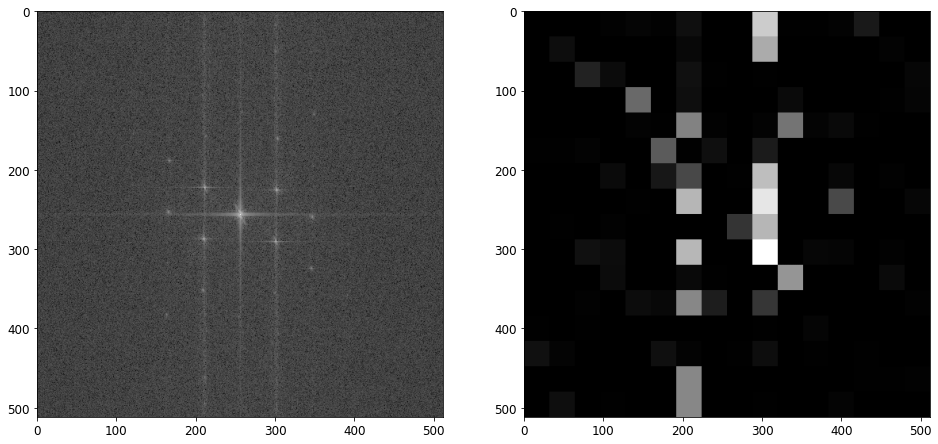

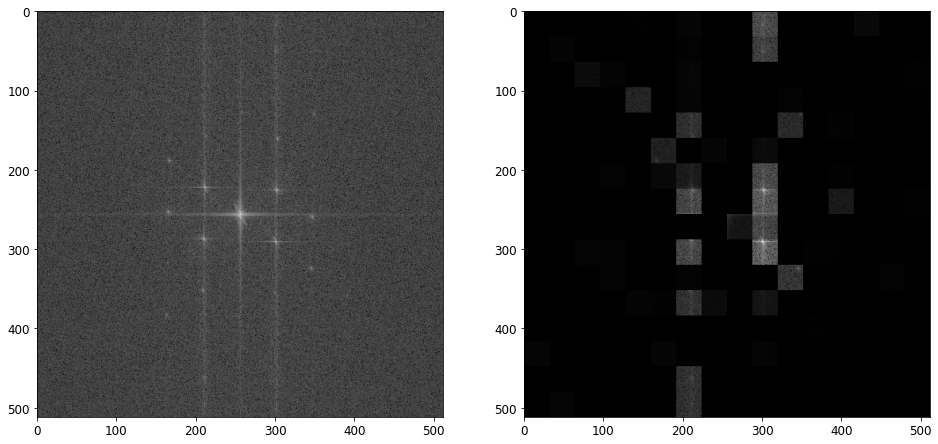

In [33]:
ii.multiplot(fft,peaks_pred, size = 8)
ii.multiplot(fft,peaks_pred*fft, size = 8)

In [134]:
np.max(peaks_pred)

0

Peak 0.9248561263084412


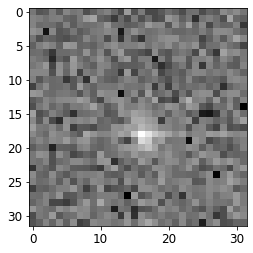

Noise 0.3493775725364685


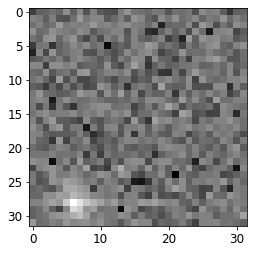

In [34]:
zoom_normalize = np.uint8(ii.normalize_image(fft[170:202, 150:182])*255)
pred = learn_inf.predict(zoom_normalize)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom_normalize, cmap = 'gray')
plt.show()

zoom_normalize = np.uint8(ii.normalize_image(fft[160:192, 160:192])*255)
pred = learn_inf.predict(zoom_normalize)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom_normalize, cmap = 'gray')
plt.show()

Peak 0.7604544758796692


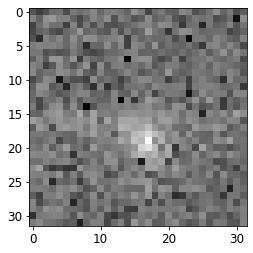

Noise 0.00190977961756289


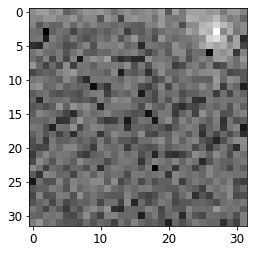

In [38]:
zoom_normalize = np.uint8(ii.normalize_image(fft[240:272, 330:362])*255)
pred = learn_inf.predict(zoom_normalize)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom_normalize, cmap = 'gray')
plt.show()

zoom_normalize = np.uint8(ii.normalize_image(fft[256:288, 320:352])*255)
pred = learn_inf.predict(zoom_normalize)

print(pred[0],float(pred[2][1]))
plt.imshow(zoom_normalize, cmap = 'gray')
plt.show()


In [170]:
for  i in range(0,520,32):
    print(i)

0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
